In [1]:
from typing import Tuple, Dict, Callable, Iterator, Union, Optional, List
import os
import sys
import yaml 

import numpy as np
import torch
from torch import Tensor

import gym

# To import module code.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.environment_api import EnvironmentObjective, manipulate_reward
from src.policy_parameterizations import MLP
from src.evaluate import (
    offline_reward_evaluation,
    postprocessing_interpolate_x,
    plot_rewards_over_calls,
)

import matplotlib.pyplot as plt
%config Completer.use_jedi = False

In [2]:
plt.style.use('seaborn-whitegrid')
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 9,
    "font.size": 9,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams.update(tex_fonts)

In [3]:
def plot_rewards_over_calls(
    rewards_optimizer: List[torch.tensor],
    names_optimizer: List[str],
    title: str,
    marker: List[str] = ["o", ">"],
    steps: int = 100,
    markevery: int = 5,
    figsize: Tuple[float] = (2.8, 1.7),
    path_savefig: Optional[str] = None,
):
    """Generate plot showing rewards over objective calls for multiple optimizer.

    Args:
        rewards_optimizer: List of torch tensors for every optimizer.
        title: Plot title.
        marker: Plot marker.
        steps: Number which defines the x-th reward that should be plotted.
        markevery: Number which defines the x-th reward which should be marked (after steps).
        path_savefig: Path where to save the resulting figure.
    """
    plt.figure(figsize=figsize)
    for index_optimizer, rewards in enumerate(rewards_optimizer):
        max_calls = rewards.shape[-1]
        m = torch.mean(rewards, dim=0)[::steps]
        std = torch.std(rewards, dim=0)[::steps]
        plt.plot(
            torch.linspace(0, max_calls, max_calls // steps),
            m,
            marker=marker[index_optimizer],
            markevery=markevery,
            markersize=3,
            label=names_optimizer[index_optimizer],
        )
        plt.fill_between(
            torch.linspace(0, max_calls, max_calls // steps),
            m - std,
            m + std,
            alpha=0.2,
        )
    plt.xlabel("\# of evaluations")
    plt.ylabel("Average Reward")
    plt.legend(loc="lower right")
    plt.title(title)
    plt.xlim([0, max_calls])
    if path_savefig:
        plt.savefig(path_savefig, bbox_inches="tight")

In [4]:
def postprocess_data(configs: List[str], postprocess: bool = True):
    
    method_to_name = {'gibo': 'GIBO', 'rs': 'ARS', 'vbo': 'Vanilla BO'}
    list_interpolated_rewards = []
    list_names_optimizer = []
    
    for cfg_str in configs:

        with open(cfg_str, 'r') as f:
            cfg = yaml.load(f, Loader=yaml.Loader)

        directory = '.' + cfg['out_dir']
        
        if postprocess:

            print('Postprocess tracked parameters over optimization procedure.')

            # Usecase 1: optimizing policy for a reinforcement learning environment.
            mlp = MLP(*cfg['mlp']['layers'], add_bias=cfg['mlp']['add_bias'])
            len_params = mlp.len_params

            # In evaluation mode manipulation of state and reward is always None.
            objective_env = EnvironmentObjective(
                env=gym.make(cfg['environment_name']),
                policy=mlp,
                manipulate_state=None,
                manipulate_reward=None,
            )

            # Load data.
            print(f'Load data from {directory}.')
            parameters = np.load(
                os.path.join(directory, 'parameters.npy'), allow_pickle=True
            ).item()
            calls = np.load(
                os.path.join(directory, 'calls.npy'), allow_pickle=True
            ).item()

            # Postprocess data (offline evaluation and interpolation).
            print('Postprocess data: offline evaluation and interpolation.')
            offline_rewards = offline_reward_evaluation(parameters, objective_env)
            interpolated_rewards = postprocessing_interpolate_x(
                offline_rewards, calls, max_calls=cfg['max_objective_calls']
            )

            # Save postprocessed data.
            print(f'Save postprocessed data in {directory}.')
            torch.save(
                interpolated_rewards, os.path.join(directory, 'interpolated_rewards.pt')
            )
            torch.save(offline_rewards, os.path.join(directory, 'offline_rewards.pt'))

        else:
            interpolated_rewards = torch.load(
                os.path.join(directory, 'interpolated_rewards.pt')
            )

        list_names_optimizer.append(method_to_name[cfg['method']])
        list_interpolated_rewards.append(interpolated_rewards)
        
    return list_names_optimizer, list_interpolated_rewards

In [7]:
(list_names_optimizer, 
 list_interpolated_rewards) = postprocess_data(configs=['../configs/rl_experiment/cartpole/rs.yaml',
                                                        '../configs/rl_experiment/cartpole/gibo.yaml',
                                                       ],
                                               postprocess = False)

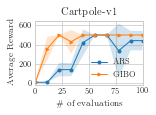

In [8]:
plt.rcParams['lines.linewidth'] = 1.
plot_rewards_over_calls(
        rewards_optimizer=list_interpolated_rewards,
        names_optimizer=list_names_optimizer,
        title='Cartpole-v1',
        marker=['o', '>'],
        steps=10,
        markevery=1,
        figsize = (1.92, 1.19),
        path_savefig=None #'../experiments/rl_experiments/cartpole/cartpole_v1.pdf',
    )

In [10]:
(list_names_optimizer, 
 list_interpolated_rewards) = postprocess_data(configs=['../configs/rl_experiment/swimmer/rs.yaml',
                                                        '../configs/rl_experiment/swimmer/gibo.yaml',
                                                       ],
                                               postprocess = False)

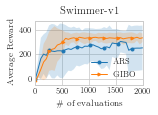

In [11]:
plt.rcParams['lines.linewidth'] = 1.
plot_rewards_over_calls(
        rewards_optimizer=list_interpolated_rewards,
        names_optimizer=list_names_optimizer,
        title='Swimmer-v1',
        marker=['o', '>'],
        steps=50,
        markevery=5,
        figsize = (1.92, 1.19),
        path_savefig=None #'../experiments/rl_experiments/swimmer/swimmer_v1.pdf',
    )

In [13]:
(list_names_optimizer, 
 list_interpolated_rewards) = postprocess_data(configs=['../configs/rl_experiment/hopper/rs.yaml',
                                                        '../configs/rl_experiment/hopper/gibo.yaml',
                                                       ],
                                               postprocess = False)

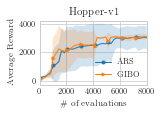

In [14]:
plt.rcParams['lines.linewidth'] = 1.
plot_rewards_over_calls(
        rewards_optimizer=list_interpolated_rewards,
        names_optimizer=list_names_optimizer,
        title='Hopper-v1',
        marker=['o', '>'],
        steps=200,
        markevery=5,
        figsize = (1.92, 1.19),
        path_savefig=None #'../experiments/rl_experiments/hopper/hopper_v1.pdf',
    )